<a href="https://colab.research.google.com/github/binchoo/NER-RESEARCH/blob/master/hackathon_2nd(%EC%9D%8C%EC%A0%88%EC%9E%84%EB%B2%A0%EB%94%A9).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


- CNN-BiGRU-CRF 모델
- 음절 단위 자질을 아래와 같이 구성함.
  - 1. 입력 음절 시퀀스에 대해, 양 끝단에 zero padding을 실시
  - 2. 각 음절 기준으로, 앞 음절과 다음 음절을 함께 CNN의 input으로 입력(Tri-gram 필터 적용 -> 문맥 반영)
  - 3. filter의 갯수(num_filter)만큼 음절을 featuring한 벡터(길이 max_length)가 출력될 것이고, 모든 filter를 참고하기 위해 mean pooling 실시
  - 4. 기존에 마련한 음절 임베딩 벡터에, mean pooling된 음절 벡터를 결합.
  - 5. 결합된 벡터를 bi-GRU Layer에 집어넣고, bi-GRU의 output은 다시 CRF layer의 input으로 들어감으로써, 개체명 인식을 수행

- 아래 그림들을 참고.
- baseline과 동일한 조건으로 학습 및 검증을 수행할 경우, 마지막 epoch 기준 f1-score macro avg 값이 baseline에 비해 0.02 ~ 0.03 높음.

- 이 모델을 채택할 때, 고려할 사항
  - 1. epoch 수
  - 2. Tri-gram filter 갯수
  - 3. embedding 차원 수
  - 4. stacked bi-GRU? vs 1층 bi-GRU?

In [33]:
root_dir = "../gdrive/MyDrive/AI/hackathon_2nd"

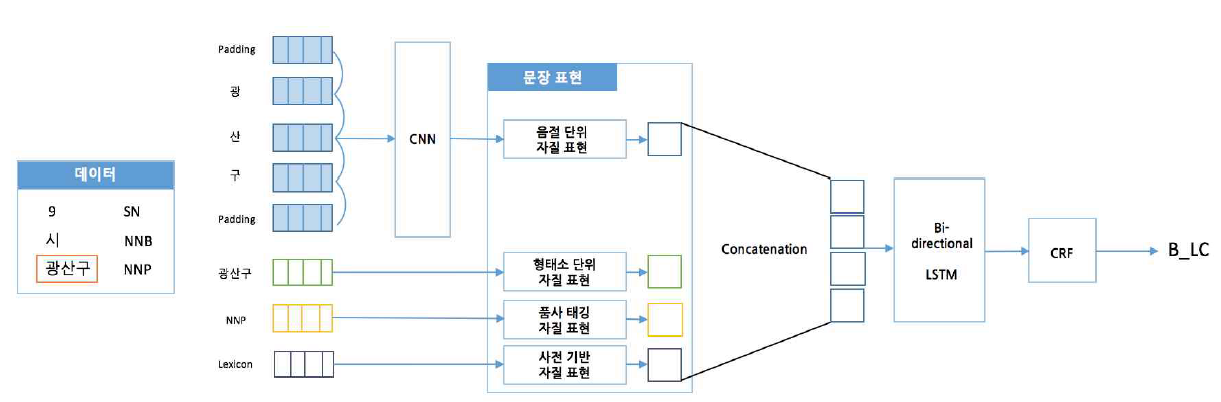

In [9]:
from IPython.display import Image
import os
Image(os.path.join(root_dir, "cnn-bigru-crf.PNG"))

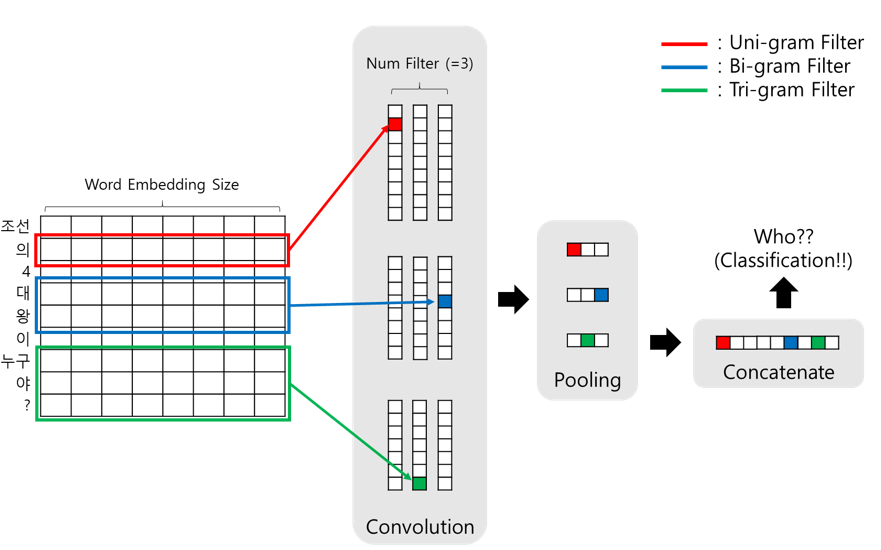

In [4]:
Image(os.path.join(root_dir, "textCNN.PNG"))

In [2]:
!pip install pytorch-crf
!pip install seqeval==1.0.0

     |████████████████████████████████| 14.5MB 245kB/s 
     |████████████████████████████████| 6.8MB 52.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.0.0-cp36-none-any.whl size=14022 sha256=8af540286fd4c193e130abcc4f045b0e42079cf9d16747731bf73a7151acade7
  Stored in directory: /root/.cache/pip/wheels/9e/82/18/6cfa15bb8d49855b0636bd72d12ab43fe9c4da8e8ba3b94db2
Successfully built seqeval
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-

In [2]:
import torch
import torch.nn as nn
from torchcrf import CRF
from torch.utils.data import (DataLoader, RandomSampler, TensorDataset)
import torch.optim as optim

from tqdm import tqdm
import numpy as np

from seqeval.metrics import classification_report

In [3]:
# tensor 객체를 리스트 형으로 바꾸기 위한 함수
def tensor2list(input_tensor):
    return input_tensor.cpu().detach().numpy().tolist()

In [31]:
# tri-gram Convolution Neural Network
class TextCNN(nn.Module):
    def __init__(self, config):
        super(TextCNN, self).__init__()

        # 전체 음절 갯수
        self.eumjeol_vocab_size = config["word_vocab_size"]

        # 단어 벡터(임베딩) 사이즈
        self.embedding_size = config["embedding_size"]
        
        # 입력 문장의 최대 길이
        self.max_length = config["max_length"]

        # CNN에 각 필터의 개수
        self.num_filters = config["num_filters"]

        # 입력 데이터에 있는 각 형태소 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        self.embedding = nn.Embedding(num_embeddings=self.eumjeol_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)

        # nn.Conv1d(in_channel, outchannel, kernel_size)
        # in_channel : 입력하는 텐서의 embedding 크기
        # out_channel : 필터 개수
        # kernel : 필터 크기
        # padding : 입력 음절 시퀀스 양단에 padding을 실시할 갯수
        self.convolution_layers = nn.ModuleList([nn.Conv1d(in_channels = self.embedding_size,
                                                           out_channels = self.num_filters,
                                                           padding = 1,
                                                           padding_mode = 'zeros',
                                                           kernel_size = 3)])


    def forward(self, input_features):
        # input_feature : [batch, max_length(음절 단위)]
        # self.embedding(input_features) : [batch, max_length, embedding_size]
        # lookup_input_features : [batch, embedding_size, max_length]
        lookup_input_features = self.embedding(input_features).permute(0,2,1)
       
        # tri-gram CNN 통과 + Max Pooling
        # lookup_input_features : [batch, embedding_size, max_length]
        # self.convolution_layers[3-gram](lookup_input_features) : [batch, num_filters, max_length]
        # ~.permute(0, 2, 1) : [batch, max_length, num_filters]
        # convolution_output = self.convolution_layers[0](lookup_input_features).permute(0, 2, 1).mean(dim=-1)[0]
        convolution_output = self.convolution_layers[0](lookup_input_features).permute(0, 2, 1).mean(dim=-1)
        convolution_output = torch.unsqueeze(input=convolution_output, dim=2)
        # convolution_output : [batch, max_length, 1]

        return torch.tensor(convolution_output)

In [5]:
class RNN_CRF(nn.Module):
    def __init__(self, config):
        super(RNN_CRF, self).__init__()

        # 전체 음절 개수
        self.eumjeol_vocab_size = config["word_vocab_size"]

        # 음절 임베딩 사이즈
        self.embedding_size = config["embedding_size"]

        # GRU 히든 사이즈
        self.hidden_size = config["hidden_size"]

        # 분류할 태그의 개수
        self.number_of_tags = config["number_of_tags"]

        # 입력 데이터에 있는 각 음절 index를 대응하는 임베딩 벡터로 치환해주기 위한 임베딩 객체
        self.embedding = nn.Embedding(num_embeddings=self.eumjeol_vocab_size,
                                      embedding_dim=self.embedding_size,
                                      padding_idx=0)

        self.dropout = nn.Dropout(config["dropout"])

        # Tri-gram Convolution Layer
        self.cnn = TextCNN(config)

        # Bi-GRU layer
        self.bi_gru = nn.GRU(input_size = (self.embedding_size + 1),
                             hidden_size= self.hidden_size,
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)

        # CRF layer
        self.crf = CRF(num_tags=self.number_of_tags, batch_first=True)

        # fully_connected layer를 통하여 출력 크기를 number_of_tags에 맞춰줌
        # (batch_size, max_length, hidden_size*2) -> (batch_size, max_length, number_of_tags)
        self.hidden2num_tag = nn.Linear(in_features=self.hidden_size*2, out_features=self.number_of_tags)

    def forward(self, inputs, labels=None):
        # (batch_size, max_length) -> (batch_size, max_length, embedding_size)
        eumjeol_inputs = self.embedding(inputs)
        # 사전에 CNN을 통과한 음절 output(batch, max_length, 1)
        eumjeol_cnn_outputs = self.cnn(inputs)
        # eumjeol_inputs : (batch_size, max_length, embedding_size + 1)
        eumjeol_inputs = torch.cat((eumjeol_inputs, eumjeol_cnn_outputs), dim=-1)

        encoder_outputs, hidden_states = self.bi_gru(eumjeol_inputs)

        # (batch_size, curr_max_length, hidden_size*2)
        d_hidden_outputs = self.dropout(encoder_outputs)

        # (batch_size, curr_max_length, hidden_size*2) -> (batch_size, curr_max_length, number_of_tags)
        logits = self.hidden2num_tag(d_hidden_outputs)

        if(labels is not None):
            log_likelihood = self.crf(emissions=logits,
                                      tags=labels,
                                      reduction="mean")

            loss = log_likelihood * -1.0

            return loss
        else:
            output = self.crf.decode(emissions=logits)

            return output

In [6]:
# 학습 코드
def train(config):
    # 모델 객체 생성
    model = RNN_CRF(config).cuda()
    # 단어, 태그 딕셔너리 생성
    word2idx, idx2word = load_vocab(config["word_vocab_file"])
    tag2idx, idx2tag = load_vocab(config["tag_vocab_file"])

    # 데이터 Load
    train_input_features, train_tags = load_data(config, config["train_file"], word2idx, tag2idx)
    test_input_features, test_tags = load_data(config, config["dev_file"], word2idx, tag2idx)

    # 불러온 데이터를 TensorDataset 객체로 변환
    train_features = TensorDataset(train_input_features, train_tags)
    train_dataloader = DataLoader(train_features, shuffle=True, batch_size=config["batch_size"])

    test_features = TensorDataset(test_input_features, test_tags)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=config["batch_size"])

    # 모델을 학습하기위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    accuracy_list = []
    for epoch in range(config["epoch"]):
        model.train()
        losses = []
        for step, batch in enumerate(train_dataloader):
            # .cuda()를 이용하여 메모리에 업로드
            batch = tuple(t.cuda() for t in batch)
            input_features, labels = batch

            # loss 계산
            loss = model.forward(input_features, labels)

            # 변화도 초기화
            optimizer.zero_grad()

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()

            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            if (step + 1) % 50 == 0:
                print("{} step processed.. current loss : {}".format(step + 1, loss.data.item()))
            losses.append(loss.data.item())



        print("Average Loss : {}".format(np.mean(losses)))

        # 모델 저장
        torch.save(model.state_dict(), os.path.join(config["output_dir_path"], "epoch_{}.pt".format(epoch + 1)))

        do_test(model, test_dataloader, idx2tag)

In [7]:
# test 코드
def test(config):
    # 모델 객체 생성
    model = RNN_CRF(config).cuda()
    # 단어 딕셔너리 생성
    word2idx, idx2word = load_vocab(config["word_vocab_file"])
    tag2idx, idx2tag = load_vocab(config["tag_vocab_file"])


    # 저장된 가중치 Load
    model.load_state_dict(torch.load(os.path.join(config["output_dir_path"], config["trained_model_name"])))

    # 데이터 Load
    test_input_features, test_tags = load_data(config, config["dev_file"], word2idx, tag2idx)

    # 불러온 데이터를 TensorDataset 객체로 변환
    test_features = TensorDataset(test_input_features, test_tags)  # (음절 시퀀스로 이루어진 문장, 태그 시퀀스)
    test_dataloader = DataLoader(test_features, shuffle=False, batch_size=config["batch_size"])
    # 평가 함수 호출
    do_test(model, test_dataloader, idx2tag)

def do_test(model, test_dataloader, idx2tag):
    model.eval()
    predicts, answers = [], []
    for step, batch in enumerate(test_dataloader):
        # .cuda() 함수를 이용하여 메모리에 업로드
        batch = tuple(t.cuda() for t in batch)

        # 데이터를 각 변수에 저장
        input_features, labels = batch  # 음절 시퀀스, 태그 시퀀스

        # 예측 라벨 출력
        output = model(input_features)

        # 성능 평가를 위해 예측 값과 정답 값 리스트에 저장
        for idx, answer in enumerate(tensor2list(labels)):
            answers.extend([idx2tag[e].replace("_", "-") for e in answer if idx2tag[e] != "<SP>" and idx2tag[e] != "<PAD>"])
            predicts.extend([idx2tag[e].replace("_", "-") for i, e in enumerate(output[idx]) if idx2tag[answer[i]] != "<SP>" and idx2tag[answer[i]] != "<PAD>"] )
    
    # 성능 평가
    print(classification_report(answers, predicts))

In [11]:
# 파라미터로 입력받은 파일에 저장된 단어 리스트를 딕셔너리 형태로 저장
def load_vocab(f_name):
    vocab_file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')
    print("{} vocab file loading...".format(f_name))

    # default 요소가 저장된 딕셔너리 생성
    symbol2idx, idx2symbol = {"<PAD>":0, "<UNK>":1}, {0:"<PAD>", 1:"<UNK>"}

    # 시작 인덱스 번호 저장
    index = len(symbol2idx)
    for line in tqdm(vocab_file.readlines()):
        symbol = line.strip()
        symbol2idx[symbol] = index
        idx2symbol[index]= symbol
        index+=1

    return symbol2idx, idx2symbol

In [12]:
# 입력 데이터를 고정 길이의 벡터로 표현하기 위한 함수
def convert_data2feature(data, symbol2idx, max_length=None):
    # data 형태 : 새 벽 출 조 시 <SP> 야 영 적 극 <SP> 권 장 하 ㅂ 니 다 <SP> . 또는 B_TI I_TI O O O <SP> O O O O <SP> O O O O O O <SP> O
    # 고정 길이의 0 벡터 생성
    feature = np.zeros(shape=(max_length), dtype=np.int)
    # 입력 문장을 공백 기준으로 split -> ['새', '벽', '출', '조', '시', '<SP>', '야', '영', '적', '극', '<SP>', '권', '장', '하', 'ㅂ', '니', '다', '<SP>', '.']
    words = data.split()

    for idx, word in enumerate(words[:max_length]):
        if word in symbol2idx.keys():
            feature[idx] = symbol2idx[word]
        else:
            feature[idx] = symbol2idx["<UNK>"]
    return feature

In [13]:
# 파라미터로 입력받은 파일로부터 tensor객체 생성
def load_data(config, f_name, word2idx, tag2idx):
    file = open(os.path.join(root_dir, f_name),'r',encoding='utf8')

    # return할 문장/라벨 리스트 생성
    indexing_inputs, indexing_tags = [], []

    print("{} file loading...".format(f_name))

    # 실제 데이터는 아래와 같은 형태를 가짐
    # 문장 \t 태그
    # 세 종 대 왕 은 <SP> 조 선 의 <SP> 4 대 <SP> 왕 이 야 \t B_PS I_PS I_PS I_PS O <SP> B_LC I_LC O <SP> O O <SP> O O O
    for line in tqdm(file.readlines()):
        try:
            id, sentence, tags = line.strip().split('\t')
        except:
            id, sentence = line.strip().split('\t')
        input_sentence = convert_data2feature(sentence, word2idx, config["max_length"])
        indexing_tag = convert_data2feature(tags, tag2idx, config["max_length"])

        indexing_inputs.append(input_sentence)
        indexing_tags.append(indexing_tag)
    indexing_inputs = torch.tensor(indexing_inputs, dtype=torch.long)
    indexing_tags = torch.tensor(indexing_tags, dtype=torch.long)

    return indexing_inputs, indexing_tags

In [32]:
##########################################################
#                                                        #
#        평가 기준이 되는 지표는 Macro F1 Score          #
#           제출 포맷은 id \t predict_tag                #
#            25 \t B_PS I_PS <SP> O O O ...              #
#                                                        #
##########################################################


import os
if(__name__=="__main__"):
    output_dir = os.path.join(root_dir, "output")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    config = {"mode": "train",
              "train_file":"ner_train.txt",
              "dev_file": "ner_dev.txt",
              "word_vocab_file":"vocab.txt",
              "tag_vocab_file":"tag_vocab.txt",
              "trained_model_name":"epoch_{}.pt".format(5),
              "output_dir_path":output_dir,
              "word_vocab_size":2160,
              "num_filters" : 32,
              "number_of_tags": 14,
              "hidden_size": 100,
              "dropout":0.2,
              "embedding_size":100,
              "max_length": 120,
              "batch_size":64,
              "epoch":20,
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

 36%|███▌      | 2636/7319 [00:00<00:00, 26354.06it/s]

vocab.txt vocab file loading...
tag_vocab.txt vocab file loading...
ner_train.txt file loading...


100%|██████████| 995/995 [00:00<00:00, 26156.40it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ner_dev.txt file loading...
50 step processed.. current loss : 21.51564598083496
100 step processed.. current loss : 14.297479629516602
Average Loss : 33.25730547697648


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:45: UserWarning: <PAD> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

          DT       0.60      0.57      0.59       609
          LC       0.54      0.44      0.48       534
          OG       0.44      0.33      0.38       963
          PS       0.63      0.39      0.48       733
          TI       0.35      0.29      0.32        94

   micro avg       0.53      0.41      0.46      2933
   macro avg       0.51      0.40      0.45      2933
weighted avg       0.53      0.41      0.46      2933

50 step processed.. current loss : 12.823389053344727
100 step processed.. current loss : 10.051321029663086
Average Loss : 11.474527193152387
              precision    recall  f1-score   support

          DT       0.73      0.59      0.65       609
          LC       0.74      0.49      0.59       534
          OG       0.61      0.46      0.52       963
          PS       0.69      0.51      0.59       733
          TI       0.66      0.47      0.55        94

   micro avg       0.67      0.51      0.5

/usr/local/lib/python3.6/dist-packages/seqeval/metrics/sequence_labeling.py:45: UserWarning: <SP> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

          DT       0.76      0.70      0.73       609
          LC       0.74      0.65      0.70       534
          OG       0.65      0.62      0.64       963
          PS       0.70      0.65      0.68       733
          TI       0.70      0.63      0.66        94

   micro avg       0.70      0.65      0.68      2933
   macro avg       0.71      0.65      0.68      2933
weighted avg       0.70      0.65      0.68      2933

50 step processed.. current loss : 1.4694061279296875
100 step processed.. current loss : 1.029984474182129
Average Loss : 1.6447234547656515
              precision    recall  f1-score   support

          DT       0.78      0.72      0.75       609
          LC       0.72      0.65      0.68       534
          OG       0.66      0.58      0.62       963
          PS       0.74      0.65      0.69       733
          TI       0.79      0.65      0.71        94

   micro avg       0.72      0.64      0.68

- baseline과 동일한 조건 하에, 
- 각 음절에 대해 사전에 CNN을 통과시켜 얻은 feature 값을 기존 음절 임베딩 벡터에 결합할 했을 때 macro avg 값이 0.02 ~ 0.03 정도 높음.
